# TD de reacteur

## 1. Introduction
### 1.1. Importation des modules

In [1]:
from scipy.integrate import odeint
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from seaborn import set_theme
from math import e
%matplotlib inline
set_theme(style='ticks', palette='tab10')

### 1.2. Définition des constantes

In [2]:
dHr = -6900 # J/mol

T0 = 330 # K

CpA = 141 # J/mol/K
CpB = 141 # J/mol/K
CpC = 161 # J/mol/K

CA0 = 9300 # mol/m3

FA0 = 146.7e+3 # mol/h
FC0 = 16.3e+3 # mol/h

Kc0 = 3.03 # adim, à 60°C
k0 = 31.1 # h-1, à 360 K
Ea = 65700 # J/mol
R = 8.314 # J/mol/K

### 1.3. Définition des fonctions

## 2. Modélisation du réacteur

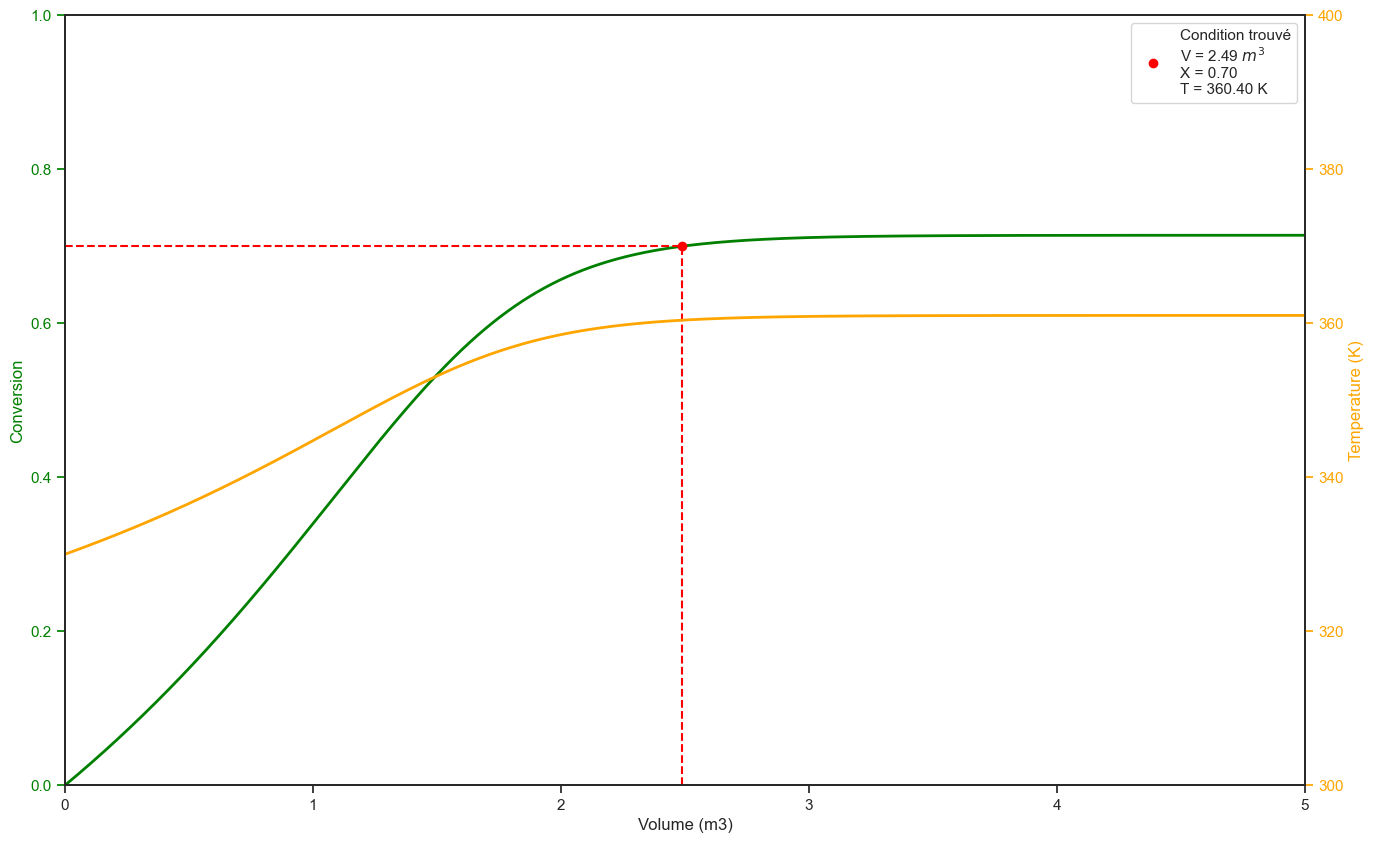

In [3]:
import numpy as np
from scipy.integrate import odeint, OdeSolver

# Define the function for the ODE
def f(X, V):
    T = 330 - dHr*X / (CpA + (1/9) * CpC)  # K
    k = k0 * e**(Ea / R * (1/360 - 1/T))  # h^-1
    Kc = Kc0 * e**(dHr / R * (1/333.15 - 1/T))  # adim
    mrA = k * CA0 * (1 - X - X/Kc) # reaction rate (mol/m3/h)
    dXdV = mrA / FA0  # mol/m^3
    return dXdV

# Define the range of volume values (V)
V_range = np.linspace(0, 5, 100001)  # Example: Volume from 0 to 5

# Define the initial condition for conversion X at V = 0
X0 = 0  # Initial conversion

# Solve the ODE using odeint
X_solution = odeint(f, X0, V_range).reshape(-1)

# Define the specific conversion point you want to highlight
conversion_point = 0.7  # Change this to the desired conversion value

# Find the index of the closest point to the specified conversion in the solution
index = np.argmin(np.abs(X_solution - conversion_point))
highlight_V = V_range[index]
highlight_X = X_solution[index]

# Plot the solution
fig, ax1 = plt.subplots(figsize=(16,10))
ax2 = ax1.twinx()

ax1.plot(V_range, X_solution, color='green', linewidth=2)
ax1.set_xlabel('Volume (m3)')
ax1.set_ylabel('Conversion', color='green')
ax1.tick_params(axis='y', colors='green')

T = 330 - dHr*X_solution / (CpA + (1/9) * CpC)  # K
ax2.plot(V_range, T, color='orange', linewidth=2)
ax2.set_ylabel('Temperature (K)', color='orange')
ax2.tick_params(axis='y', colors='orange')

# Add a horizontal line from the y-axis to the point
ax1.hlines(highlight_X, 0, highlight_V, colors='red', linestyles='dashed')
ax1.set_xlim(0, V_range[-1])

# Add a vertical line from the x-axis to the point
ax1.vlines(highlight_V, 0, highlight_X, colors='red', linestyles='dashed')
ax1.set_ylim(0, 1)
ax2.set_ylim(300, 400)

# Highlight the specific point with a red dot
ax1.plot(highlight_V, highlight_X, 'ro', label=f'Condition trouvé\nV = {highlight_V:.2f} $m^3$\nX = {highlight_X:.2f}\nT = {T[index]:.2f} K')

ax1.legend()
plt.show()

In [4]:
xeb = (CpA + (1/9) * CpC) * (360.4 - T0)/dHr
xeb

-0.7000322061191621

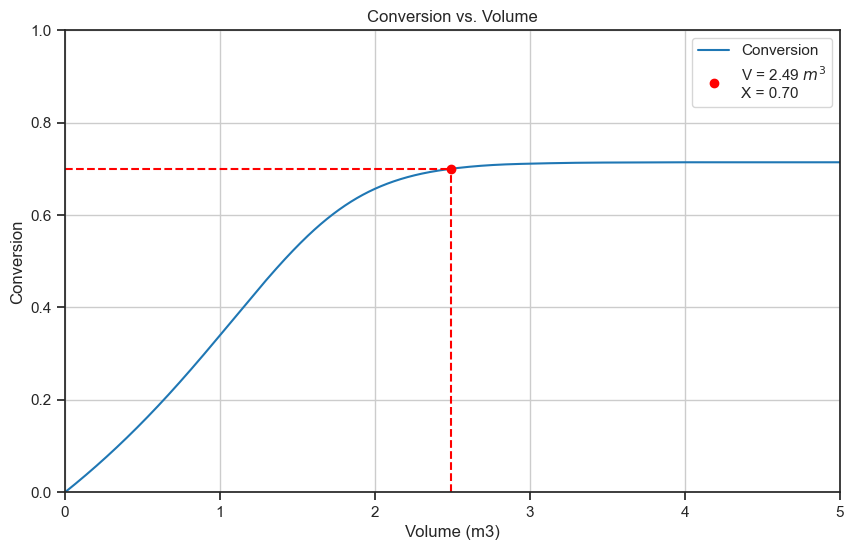

In [5]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

def adiabatique(V, Y): # Y = [X, T] = [conversion, temperature]
    k = k0 * e**(Ea / R * (1/360 - 1/Y[1])) # kinetic constant (h^-1)
    #print('k: ', k)
    Kc = Kc0 * e**(dHr / R * (1/333.15 - 1/Y[1])) # equilibrium constant (adim)
    #print('Kc: ', Kc)
    mrA = k * CA0 * (1 - Y[0] - Y[0]/Kc) # reaction rate (mol/m3/h)
    #print('-rA: ', mrA)
    dY = np.zeros(2)
    dY[0] = mrA / FA0
    dY[1] = (mrA * -dHr) / (FA0 * (CpA + CpC/9))
    return dY

solution = solve_ivp(adiabatique, [0, 5], [0, 330], method='RK45', t_eval=np.linspace(0, 5, 100000))
X_solution = solution.y[0]
V_range = solution.t

# Define the specific conversion point you want to highlight
conversion_point = 0.7  # Change this to the desired conversion value

# Find the index of the closest point to the specified conversion in the solution
index = np.argmin(np.abs(X_solution - conversion_point))
highlight_V = V_range[index]
highlight_X = X_solution[index]

# Plot the solution
plt.figure(figsize=(10, 6))
plt.plot(solution.t, solution.y[0], label='Conversion')
plt.xlabel('Volume (m3)')
plt.ylabel('Conversion')
plt.title('Conversion vs. Volume')

# Add a horizontal line from the y-axis to the point
plt.hlines(highlight_X, 0, highlight_V, colors='red', linestyles='dashed')
plt.xlim(0, V_range[-1])

# Add a vertical line from the x-axis to the point
plt.vlines(highlight_V, 0, highlight_X, colors='red', linestyles='dashed')
plt.ylim(0, 1)

# Highlight the specific point with a red dot
plt.plot(highlight_V, highlight_X, 'ro', label=f'V = {highlight_V:.2f} $m^3$\nX = {highlight_X:.2f}')

plt.grid()
plt.legend()
plt.show()

### Simulation differentielle

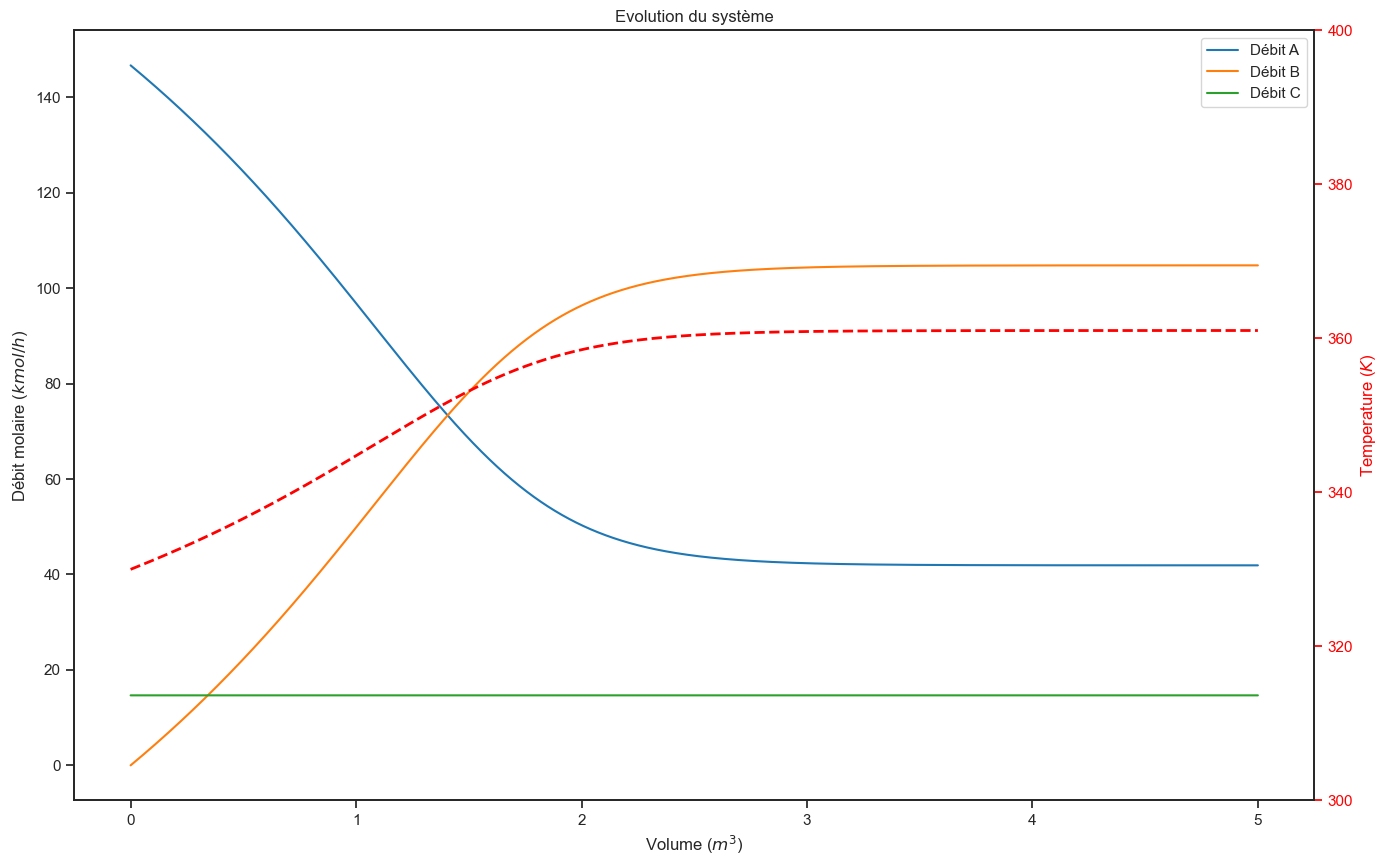

In [6]:
def edos(x, V):
    # Unpack variables
    FA, FB, FC, T = x
    # Calculate the reaction parameters
    k = k0 * e**(Ea / R * (1/360 - 1/T)) # kinetic constant (h^-1)
    Kc = Kc0 * e**(dHr / R * (1/333.15 - 1/T)) # equilibrium constant (adim) 
    # Calculate the reaction rates
    dFadV = -k*FA/v0 + k/Kc*FB/v0
    dFbdV = -k/Kc*FB/v0 + k*FA/v0
    dFcdV = 0
    dTdV = (-(k*FA/v0 - k/Kc*FB/v0) * dHr) / (FA0 * (CpA + CpC/9))
    
    return [dFadV, dFbdV, dFcdV, dTdV]

v0 = FA0/CA0 # m3/h
F0 = [FA0, 0, 0.1*FA0, 330]
V = np.linspace(0, 5, 10000)

result = odeint(edos, F0, V)
Fa, Fb, Fc, T = result.T

fig, ax1 = plt.subplots(figsize=(16,10))
ax2 = ax1.twinx()

ax1.plot(V, Fa/1000, label='Débit A')
ax1.plot(V, Fb/1000, label='Débit B')
ax1.plot(V, Fc/1000, label='Débit C')
ax2.plot(V, T, label='Temperature ($K$)', color='red', linestyle='dashed', linewidth=2)

ax1.set_xlabel('Volume ($m^3$)')
ax1.set_ylabel('Débit molaire ($kmol/h$)')
ax2.set_ylabel('Temperature ($K$)', color='red')
ax1.tick_params(axis='y')
ax2.tick_params(axis='y', colors='red')
ax2.set_ylim(300, 400)

ax1.legend(loc='upper right')
plt.title('Evolution du système')
plt.show()

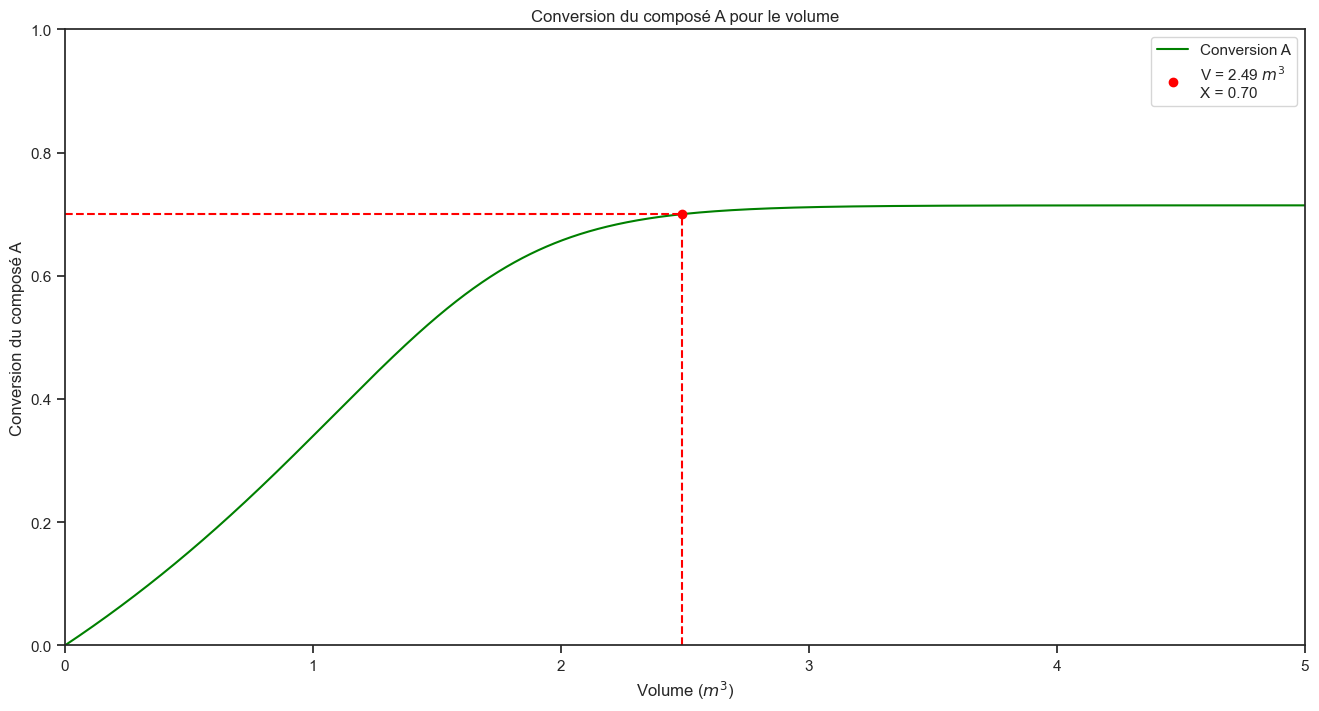

In [7]:
# Define a function to calculate the conversion of A at a given volume
def conversion_A_at_volume(V, Fa, FA0):
    return 1 - Fa / FA0

# Calculate the conversion of A along the volume
conversion_A = conversion_A_at_volume(V, Fa, FA0)

# Plot the conversion of A
plt.figure(figsize=(16, 8))
plt.plot(V, conversion_A, label='Conversion A', color='green')
plt.ylim(0, 1)
plt.xlim(0, V[-1])
plt.xlabel('Volume ($m^3$)')
plt.ylabel('Conversion du composé A')

# Find the index where conversion_A first reaches or exceeds 0.7
index_limit = np.argmax(conversion_A >= 0.7)
highlight_V = V[index_limit]
highlight_X = 0.7

# Add a horizontal line from the y-axis to the point
plt.hlines(highlight_X, 0, highlight_V, colors='red', linestyles='dashed')
plt.xlim(0, V_range[-1])

# Add a vertical line from the x-axis to the point
plt.vlines(highlight_V, 0, highlight_X, colors='red', linestyles='dashed')
plt.ylim(0, 1)

# Highlight the specific point with a red dot
plt.plot(highlight_V, highlight_X, 'ro', label=f'V = {highlight_V:.2f} $m^3$\nX = {highlight_X:.2f}')

plt.legend()
plt.title('Conversion du composé A pour le volume')
plt.show()
